# Bigram using NN

As seen previously, we defined the negative log likelihood (NLL) loss function; so now using backprop lets train a NN to make a better bigram model. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [32]:
# define stoi 
stoi = {}
allletters = sorted(set("".join(words)))

stoi = {s:i+1 for i,s in enumerate(allletters)}
stoi['.'] = 0


In [34]:
# create the training dataset of bigrams
# input x (first char) -> output y (second char): bigram is ready

xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ya = torch.tensor(ys)


. e
e m
m m
m a
a .


In [45]:
# mapping from char1 to char2
xs,ys

(tensor([ 0,  5, 13, 13,  1]), [5, 13, 13, 1, 0])

### Intuition for training

The prized question now is: how do we feed in this data into the NN?

Feeding in integers 5,13,8 etc which are just indices of characters and calculating losses is incorrect, since a = 1 and e = 5 dont have a 'five times relation'. Its a bit like a categorical variable we are dealing with, under integral labels. 

__So we will one hot encode the input and output vectors and compute the softmax loss!__

Check data structures nb for [one hot](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) experimentation in torch. 

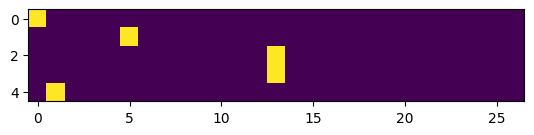

In [52]:
import torch.nn.functional as F

# specify num_classes since by looking at a part of the dataset one_hot may guess no of classes incorrectly. 
xenc = F.one_hot(xs, num_classes=27).float() # default dtype is int32, but while training float is preferred. 

plt.imshow(xenc) # to visualize

### Single neuron construction

In [67]:
W = torch.randn((27,1)) # single neuron
xenc @ W # (5,27) * (27,1) = (5,1)

# basically the scalar output of the neuron (wo bias) for 5 samples 

tensor([[ 0.2740],
        [ 0.3014],
        [-0.5839],
        [-0.5839],
        [ 1.0128]])

In [75]:
W = torch.randn((27,27)) # 27 neurons
xenc @ W # matrix multiplication (5,27) * (27,27) = (5,27)

# (27,1) output of the neuron (wo bias) for each of 5 samples makes it (5,27)

tensor([[-0.1149,  0.1075,  0.9584,  1.1891,  1.6155,  0.8580,  0.4314,  0.4452,
          0.8832, -1.6896,  0.5869, -0.0805,  0.3022,  0.3824,  0.9041, -0.7012,
         -1.0831, -1.2393, -1.3438,  1.3184,  0.0106,  0.5186, -0.4701,  0.2824,
          0.4838, -0.4408,  1.6015],
        [-1.1298, -0.2569, -1.5779, -0.8528,  0.7822, -0.5080,  0.0917,  1.0650,
          0.6506, -1.4826, -0.8991, -0.7431, -0.9734,  1.0236, -0.3331,  0.8194,
          1.4100, -1.2551, -0.8014, -0.2671,  0.1772,  2.2444, -0.7689,  0.4353,
         -0.6708, -0.7759,  1.2784],
        [-0.8892,  0.5963,  1.1437, -0.5157,  1.7922,  0.1629, -0.6869, -0.9062,
          2.4856, -0.5689, -1.1411,  1.1324,  0.2268, -0.2285, -0.1037,  0.1417,
         -0.0987, -0.3472,  0.2856,  1.0905,  0.4423, -0.5826,  1.3623, -0.3924,
          0.6072,  0.5803,  1.3126],
        [-0.8892,  0.5963,  1.1437, -0.5157,  1.7922,  0.1629, -0.6869, -0.9062,
          2.4856, -0.5689, -1.1411,  1.1324,  0.2268, -0.2285, -0.1037,  0.1417

Interpretation of `W = torch.randn((27,27))` or `W = torch.randn((27,20))` to avoid confusion:

- dim 0 = 27 = must match # of input features (depends on data) 
- dim 1 = 1 or 20 or 27 -- no of neurons (choice of user)

What does the value `(xenc @ W)[3,13]` indicate?
- The response of the 13th neuron on looking at the 3rd input!



In [73]:
print((xenc @ W)[3,13])

print(xenc[3] @ W[13])

tensor(-0.5270)
tensor(-0.5270)


## Futher intuition 

1. We will restrict the NN to just a single layer of 27 neurons with no bias, for this tutorial. 

2. We will use the Softmax activation to interpret outputs of the NN. Remember we saw the importance of activation in MLP -- without which a NN is reduced to Lin Regression -- in CS229. 

3. The output above of `(xenc @ W)` is not a prob distribution (sum $\neq$ 1, not between 0 and 1 either)

4. So how do we connect `(xenc @ W)` to a prob distribution to sample next character for our bigram model?

### Le voilà: introduce softmax

__Process:__ Exponentiate the entries of `(xenc @ W)` $\rightarrow$ sum them up row-wise $\rightarrow$ divide them to create a prob map equivalent to `P` or `N2` in the simple bigram1 notebook. 

In [86]:
logits = xenc @ W 
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

# check any row and it sum
probs[1], probs[1].sum()

(tensor([0.0080, 0.0191, 0.0051, 0.0105, 0.0540, 0.0149, 0.0271, 0.0717, 0.0473,
         0.0056, 0.0101, 0.0117, 0.0093, 0.0688, 0.0177, 0.0561, 0.1012, 0.0070,
         0.0111, 0.0189, 0.0295, 0.2331, 0.0115, 0.0382, 0.0126, 0.0114, 0.0887]),
 tensor(1.))

Alternatively, the [nn.Softmax()](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) class can be directly used. 

In [87]:
m = nn.Softmax(dim = 1)
out = m(logits)
out[1]

tensor([0.0080, 0.0191, 0.0051, 0.0105, 0.0540, 0.0149, 0.0271, 0.0717, 0.0473,
        0.0056, 0.0101, 0.0117, 0.0093, 0.0688, 0.0177, 0.0561, 0.1012, 0.0070,
        0.0111, 0.0189, 0.0295, 0.2331, 0.0115, 0.0382, 0.0126, 0.0114, 0.0887])

So now the task is: __how to find the optimum `W` using backprop__?